In [15]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import folium
from folium import plugins
from folium.plugins import HeatMap
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from google.colab import files

In [16]:
#upload dogecoin datasets
#uploaded = files.upload()

Saving full_data__4__2019.csv to full_data__4__2019.csv
Saving full_data__4__2020.csv to full_data__4__2020.csv
Saving full_data__4__2021.csv to full_data__4__2021.csv


In [14]:

#uploaded = files.upload()

KeyboardInterrupt: ignored

In [99]:
df = pd.read_csv('musktweets.csv')

In [54]:
doge_coin_2019 = pd.read_csv("full_data__4__2019.csv")
doge_coin_2020 = pd.read_csv("full_data__4__2020.csv")
doge_coin_2021 = pd.read_csv("full_data__4__2021.csv")

In [55]:
doge_coin_2019['timestamp'] = pd.to_datetime(doge_coin_2019['timestamp'], unit = 's')

In [56]:
doge_coin_2020['timestamp'] = pd.to_datetime(doge_coin_2020['timestamp'], unit = 's')

In [57]:
doge_coin_2021['timestamp'] = pd.to_datetime(doge_coin_2021['timestamp'], unit = 's')

In [58]:
pdList = [doge_coin_2019, doge_coin_2020,doge_coin_2021]  # List of your dataframes
new_df = pd.concat(pdList)

In [59]:
new_df = new_df.rename(columns = {'timestamp':'date'})

In [60]:

new_df = new_df.set_index("date")

In [61]:
dogecoin_dataset = new_df.resample('1H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last','Volume':'sum'})

In [62]:
dogecoin_dataset = dogecoin_dataset.reset_index()

In [63]:
dogecoin_dataset

,date,Open,High,Low,Close,Volume
0,2019-04-12 14:00:00,0.002775,0.002812,0.002771,0.002801,1.605356e+07
1,2019-04-12 15:00:00,0.002802,0.002835,0.002794,0.002798,4.460682e+07
2,2019-04-12 16:00:00,0.002799,0.002839,0.002790,0.002824,3.102449e+07
3,2019-04-12 17:00:00,0.002825,0.002835,0.002805,0.002810,7.427482e+06
4,2019-04-12 18:00:00,0.002811,0.002831,0.002810,0.002818,2.361975e+06
...,...,...,...,...,...,...
23021,2021-11-26 19:00:00,0.203800,0.205400,0.203400,0.203700,3.085194e+07
23022,2021-11-26 20:00:00,0.203700,0.206500,0.203200,0.206200,3.757056e+07
23023,2021-11-26 21:00:00,0.206100,0.206600,0.203100,0.203200,3.312736e+07
23024,2021-11-26 22:00:00,0.203200,0.204900,0.202200,0.202700,3.297797e+07


In [67]:
dogecoin_dataset.dtypes


date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

In [123]:
df.dtypes

SENDER                int64
MESSAGE              object
date                 object
is_crypto_related      bool
dtype: object

In [106]:
df['date'] = pd.to_datetime(df['date'])



In [103]:
df['date'] = df['date'].dt.floor('H')
df['date'] = df['date'].dt.strftime("%Y-%m-%d %H:%M:%S")

In [112]:
df = df.rename(columns = {'Unnamed: 0':'SENDER'})

In [113]:
df.head()

,SENDER,MESSAGE,date,is_crypto_related
0,0,"Please ignore prior tweets, as that was someon...",2010-06-04 18:00:00,False
1,1,Went to Iceland on Sat to ride bumper cars on ...,2011-12-01 09:00:00,False
2,2,I made the volume on the Model S http://ow.ly/...,2011-12-01 10:00:00,False
3,3,"Great Voltaire quote, arguably better than Twa...",2011-12-03 08:00:00,False
4,4,That was a total non sequitur btw\n26\n14\n50,2011-12-03 08:00:00,False


In [121]:
# Keyword Matching for dataseet
crypto_keywords = ["Bitcoin", "BTC", "Crypto", "Cryptocurrency", "Dogecoin", "Bit coin", "Cryptomarket", "Market", "crypto", "bitcoin"]
df['is_crypto_related'] = False

for keyword in crypto_keywords:
    df['is_crypto_related'] |= df['MESSAGE'].str.contains(keyword, case=False)

df = df.sort_values('date')
dogecoin_dataset = dogecoin_dataset.sort_values('date')

# merging the datasets
df['date'] = pd.to_datetime(df['date'])
dogecoin_dataset['date'] = pd.to_datetime(dogecoin_dataset['date'])

merged_data = pd.merge_asof(df, dogecoin_dataset, left_on='date', right_on='date')
grouped_data = merged_data.groupby('SENDER')
grouped_data.head()

# Mean Bitcoin before and after
hours_before = 48
hours_after = 48

mean_prices = []
dates = []

for sender, data in grouped_data:
    tweet_dates = data['date']
    for tweet_date in tweet_dates:
        start_time = tweet_date - pd.Timedelta(hours=hours_before)
        end_time = tweet_date + pd.Timedelta(hours=hours_after)
        prices_before = data[(data['date'] >= start_time) & (data['date'] < tweet_date)]['Close']
        prices_after = data[(data['date'] > tweet_date) & (data['date'] <= end_time)]['Close']
        mean_before = prices_before.mean()
        mean_after = prices_after.mean()
        mean_prices.append(mean_after - mean_before)
        dates.append(tweet_date)

# new result df
result_df = pd.DataFrame({'date': dates, 'price_change': mean_prices})

# defining threshold for the price movement
threshold = 2500
significant_changes = result_df[abs(result_df['price_change']) > threshold]

# falls and jumps
price_jumps = significant_changes[significant_changes['price_change'] > 0]
price_falls = significant_changes[significant_changes['price_change'] < 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=price_jumps['date'], y=price_jumps['price_change'],
                         mode='markers', marker=dict(color='green'), name='Price jump'))
fig.add_trace(go.Scatter(x=price_falls['date'], y=price_falls['price_change'],
                         mode='markers', marker=dict(color='red'), name='Price fall'))
fig.update_layout(title='Dogecoin price movement after Elon Musks Tweets',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Price Movement'))
fig.show()


In [116]:
from math import ceil, sqrt

def movmean(v, kb, kf):
    """
    Computes the mean with a window of length kb+kf+1 that includes the element
    in the current position, kb elements backward, and kf elements forward.
    Nonexisting elements at the edges get substituted with NaN.
    Args:
        v (list(float)): List of values.
        kb (int): Number of elements to include before current position
        kf (int): Number of elements to include after current position
    Returns:
        list(float): List of the same size as v containing the mean values
    """
    m = len(v) * [np.nan]
    for i in range(kb, len(v)-kf):
        m[i] = np.mean(v[i-kb:i+kf+1])
    return m


def LeeMykland(S, sampling, significance_level=0.01):
    """
    "Jumps in Equilibrium Prices and Market Microstructure Noise"
    - by Suzanne S. Lee and Per A. Mykland

    "https://galton.uchicago.edu/~mykland/paperlinks/LeeMykland-2535.pdf"

    Args:
        S (list(float)): An array containing prices, where each entry
                         corresponds to the price sampled every 'sampling' minutes.
        sampling (int): Minutes between entries in S
        significance_level (float): Defaults to 1% (0.001)

    Returns:
        A pandas dataframe containing a row covering the interval
        [t_i, t_i+sampling] containing the following values:
        J:   Binary value is jump with direction (sign)
        L:   L statistics
        T:   Test statistics
        sig: Volatility estimate
    """
    tm = 252*24*60 # Trading minutes
    k   = ceil(sqrt(tm/sampling))
    r = np.append(np.nan, np.diff(np.log(S)))
    bpv = np.multiply(np.absolute(r[:]), np.absolute(np.append(np.nan, r[:-1])))
    bpv = np.append(np.nan, bpv[0:-1]).reshape(-1,1) # Realized bipower variation
    sig = np.sqrt(movmean(bpv, k-3, 0)) # Volatility estimate
    L   = r/sig
    n   = np.size(S) # Length of S
    c   = (2/np.pi)**0.5
    Sn  = c*(2*np.log(n))**0.5
    Cn  = (2*np.log(n))**0.5/c - np.log(np.pi*np.log(n))/(2*c*(2*np.log(n))**0.5)
    beta_star   = -np.log(-np.log(1-significance_level)) # Jump threshold
    T   = (abs(L)-Cn)*Sn
    J   = (T > beta_star).astype(float)
    J   = J*np.sign(r) # Add direction
    # First k rows are NaN involved in bipower variation estimation are set to NaN.
    J[0:k] = np.nan
    # Build and return result dataframe
    return pd.DataFrame({'L': L,'sig': sig, 'T': T,'J':J})


prices = merged_data['Open'].tolist()

sampling = 60

result = LeeMykland(prices, sampling)

merged_data = pd.concat([merged_data, result], axis=1)

merged_data.head()


<ipython-input-116-0c1e866dc9e8>:48: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-116-0c1e866dc9e8>:48: RuntimeWarning:

invalid value encountered in true_divide



,SENDER,MESSAGE,date,is_crypto_related,Open,High,Low,Close,Volume,L,sig,T,J
0,0,"Please ignore prior tweets, as that was someon...",2010-06-04 18:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Went to Iceland on Sat to ride bumper cars on ...,2011-12-01 09:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,I made the volume on the Model S http://ow.ly/...,2011-12-01 10:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"Great Voltaire quote, arguably better than Twa...",2011-12-03 08:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,That was a total non sequitur btw\n26\n14\n50,2011-12-03 08:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merged_data.head(555)

,SENDER,MESSAGE,date,is_crypto_related,unix,symbol,open,high,low,close,Volume BTC,Volume USD,L,sig,T,J
0,-1001153434921,"I love science, bitch!",2018-09-21 05:00:00,False,1537506000,BTC/USD,6543.23,6547.45,6519.56,6531.34,1076859.99,164.86,NaN,NaN,NaN,NaN
1,-1001153434921,Here's a [@Tesla](https://twitter.com/Tesla?re...,2018-09-21 19:00:00,False,1537556400,BTC/USD,6733.72,6775.34,6726.76,6753.09,2588323.98,383.44,NaN,NaN,NaN,NaN
2,-1001153434921,"Скоро осуществим твиты на русском, ведётся раб...",2018-09-21 19:00:00,False,1537556400,BTC/USD,6733.72,6775.34,6726.76,6753.09,2588323.98,383.44,NaN,NaN,NaN,NaN
3,-1001153434921,Probably 2028 for a base to be built— Elon Mus...,2018-09-21 21:00:00,False,1537563600,BTC/USD,6708.33,6741.59,6691.28,6713.09,1683900.57,250.84,NaN,NaN,NaN,NaN
4,-1001153434921,[pic.twitter.com/Fn0hKJd3uJ](https://t.co/Fn0h...,2018-09-21 21:00:00,False,1537563600,BTC/USD,6708.33,6741.59,6691.28,6713.09,1683900.57,250.84,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,-1001153434921,Obv must be more pointy tho— Elon Musk (@elonm...,2019-01-11 10:00:00,False,1547200800,BTC/USD,3635.82,3642.51,3605.73,3627.87,2099188.65,578.06,-0.604066,0.006199,-15.975623,-0.0
551,-1001153434921,Falcon 9 and 10 Iridium NEXT satellites vertic...,2019-01-11 11:00:00,False,1547204400,BTC/USD,3627.87,3640.00,3626.22,3640.00,1544831.08,425.28,-0.351428,0.006229,-16.873535,-0.0
552,-1001153434921,"Ok— Elon Musk (@elonmusk) [January 12, 2019](h...",2019-01-12 21:00:00,False,1547326800,BTC/USD,3632.35,3641.12,3626.27,3628.93,233169.99,64.20,0.197857,0.006237,-17.419349,0.0
553,-1001153434921,View of SpaceX Dragon 1 berthed with [@Space_S...,2019-01-13 18:00:00,False,1547402400,BTC/USD,3519.40,3523.96,3499.55,3504.24,2120489.27,604.00,-5.062158,0.006240,-0.130901,-0.0


In [117]:
filtered_df = merged_data[merged_data['J'] == 1]

filtered_df.head()

,SENDER,MESSAGE,date,is_crypto_related,Open,High,Low,Close,Volume,L,sig,T,J
6747,18926,When we talk about the enormity of the cosmos💫...,2019-04-15 03:00:00,False,0.002862,0.002870,0.002850,0.002867,1.885033e+07,10.750618,0.000423,20.065932,1.0
6759,5350,"Replying to \n@Erdayastronaut\nIt can, but the...",2019-04-16 05:00:00,False,0.002744,0.002750,0.002735,0.002743,1.644071e+06,8.621443,0.000423,12.329247,1.0
6769,18912,It’s not a big deal. Charge to 90% to 95% & yo...,2019-04-16 18:00:00,False,0.002780,0.002781,0.002755,0.002758,1.528556e+06,11.246456,0.001516,21.867634,1.0
6781,18904,"Universe is big, but rendering complexity is n...",2019-04-19 00:00:00,False,0.002945,0.002947,0.002893,0.002899,3.021105e+07,27.951460,0.002089,82.567826,1.0
6848,18855,"&hearts;️ 🇯🇵— Elon Musk (@elonmusk) [April 21,...",2019-04-21 21:00:00,False,0.002692,0.002739,0.002691,0.002734,6.015288e+06,9.340245,0.001079,14.941124,1.0


In [118]:
final_df = filtered_df[(filtered_df['is_crypto_related'] == True) & (filtered_df['J'] == 1)]
final_df

,SENDER,MESSAGE,date,is_crypto_related,Open,High,Low,Close,Volume,L,sig,T,J
12943,7781,"Replying to \n@jk_rowling\nPretty much, althou...",2020-05-15 22:00:00,True,0.002505,0.002539,0.002505,0.002520,3.898255e+06,inf,0.000000,inf,1.0
15461,13516,“The future of cars can and will be electric i...,2020-10-11 19:00:00,True,0.002684,0.002685,0.002660,0.002665,3.278901e+07,7.573565,0.000968,8.521621,1.0
18089,10059,Replying to \n@sadiaslayy\n and \n@DogecoinBet...,2021-04-15 21:00:00,True,0.184194,0.194900,0.174223,0.181094,2.532291e+09,12.996225,0.025022,28.225687,1.0
18409,11860,SpaceX launching satellite Doge-1 to the moon ...,2021-05-09 23:00:00,True,0.575088,0.585000,0.560710,0.570360,5.838664e+08,17.236227,0.016750,43.632384,1.0
21054,11317,Replying to \n@Teslarati\n and \n@ResidentSpon...,2021-10-28 15:00:00,True,0.306200,0.324100,0.302300,0.318800,7.115936e+08,61.616605,0.003967,204.895286,1.0
21058,10305,@Teslarati @ResidentSponge GM & Chrysler were ...,2021-10-28 16:00:00,True,0.318800,0.331100,0.309400,0.327900,8.209480e+08,10.165222,0.003967,17.938805,1.0


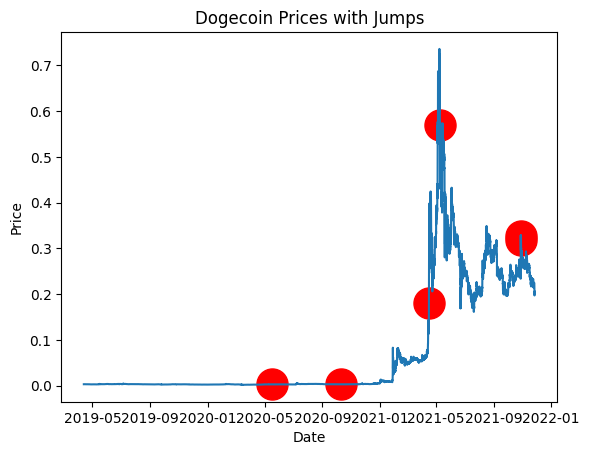

In [119]:
import matplotlib.pyplot as plt

plt.plot(dogecoin_dataset['date'], dogecoin_dataset['Close'], label='Prices')

jump_indices = final_df[final_df['J'] == 1].index
jump_dates = final_df.loc[jump_indices, 'date']
jump_prices = final_df.loc[jump_indices, 'Close']
plt.scatter(jump_dates, jump_prices, color='red', marker='o', s=500, alpha=1, label='Jumps')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dogecoin Prices with Jumps')
plt.show()
